In [25]:
# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer

# Default
from collections import Counter
import os
import urllib.request

# specific packages
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np

import tensorflow as tf
from tensorflow.python.eager import context

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv("../data/gca_peptides_for_deeplc.csv")
df.fillna("",inplace=True)
df.index = df["seq"]+"+"+df["modifications"]

In [7]:
df_pred = df.drop_duplicates(["seq","modifications"])

In [8]:
# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC()
preds_calib = dlc.make_preds(seq_df=df_pred,calibrate=False)

14/14 [==============================] - 0s 7ms/step


In [11]:
df_pred["preds_tr"] = preds_calib

In [19]:
pred_dict = df_pred["preds_tr"].to_dict()
df["preds_tr"] = [pred_dict[v] for v in df.index]

In [35]:
df_median = df.groupby(["seq","modifications"]).median().reset_index()
df_mean = df.groupby(["seq","modifications"]).mean().reset_index()
df_first = df.sort_values("tr").drop_duplicates(["seq","modifications"])

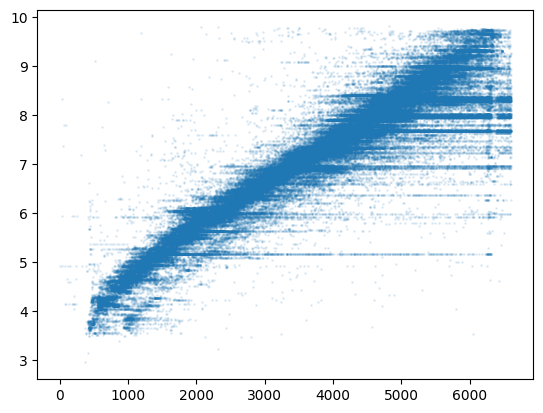

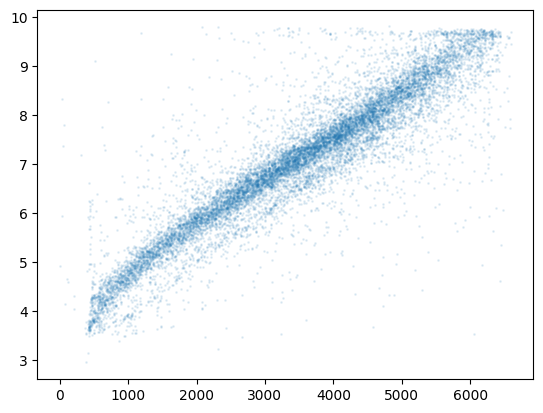

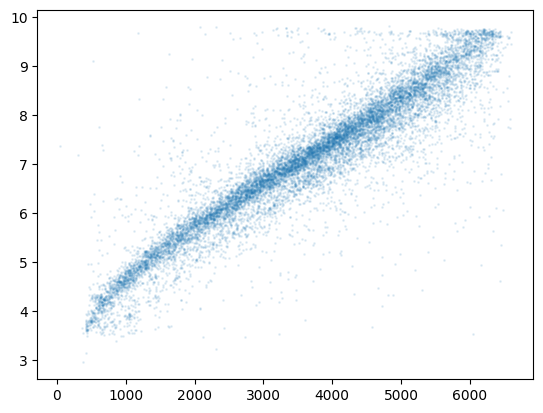

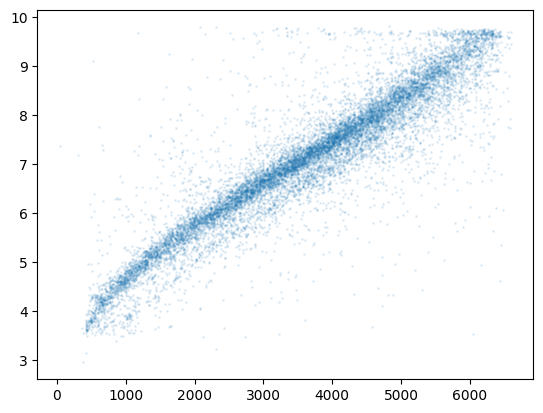

In [36]:
plt.scatter(df["tr"],df["preds_tr"],s=1,alpha=0.1)
plt.show()

plt.scatter(df_first["tr"],df_first["preds_tr"],s=1,alpha=0.1)
plt.show()

plt.scatter(df_mean["tr"],df_mean["preds_tr"],s=1,alpha=0.1)
plt.show()

plt.scatter(df_median["tr"],df_median["preds_tr"],s=1,alpha=0.1)
plt.show()

In [37]:
# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_median)
preds_calib = dlc.make_preds(seq_df=df_median)

mae_calib = sum(abs(df_median["tr"]-preds_calib))/len(df_median["tr"].index)
perc95_calib = np.percentile(abs(df_median["tr"]-preds_calib),95)*2
cor_calib = pearsonr(df_median["tr"],preds_calib)[0]

14/14 [==============================] - 0s 9ms/step


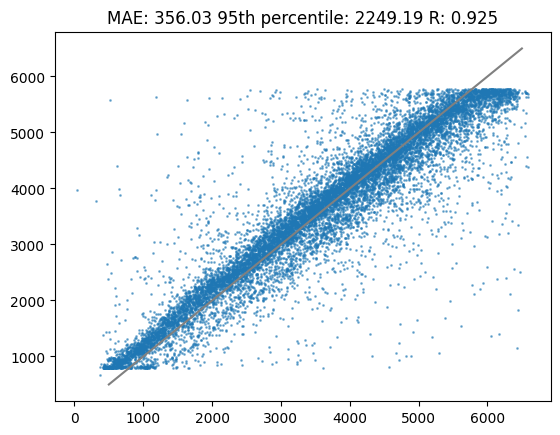

In [39]:
plt.title(f"MAE: {round(mae_calib,2)} 95th percentile: {round(perc95_calib,2)} R: {round(cor_calib,3)}")
plt.scatter(df_median["tr"],preds_calib,s=1,alpha=0.5)
plt.plot([500,6500],[500,6500],c="grey")
plt.show()

In [48]:
df_median["preds_tr"] = preds_calib

In [49]:
df_median["error"] = df_median["tr"]-df_median["preds_tr"]
df_median["abserror"] = abs(df_median["error"])

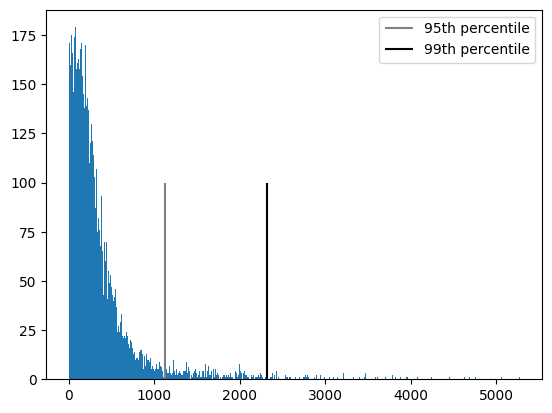

In [62]:
plt.hist(df_median["abserror"],bins=1000)
plt.vlines(np.percentile(df_median["abserror"],95),0,100,color="grey",label="95th percentile")
plt.vlines(np.percentile(df_median["abserror"],99),0,100,color="black",label="99th percentile")
plt.legend()
plt.show()